There are many techniques that can be used to advance the autonomous driving problem. This notebook will start from the very beginning, showing why many solutions do not work, and end with an exploration of a preference learning based approach. There will be a combination of driving and non-driving examples.

# Following a Path
Given a path, robotics has a solution for following the path. The general control scheme in robotics can be represented by the following block diagram:

![Control Block Diagram](plots/Control_Diagram.jpg)

Here the plant (or robot), generates some sort of output signal which we match against a reference signal. We take the difference to produce and error which is plugged into the controller which produces a control signal to hopefully correct for the error. If your control is good, the output signal should eventually match the reference signal. Perhaps the most obvious controller is a simple gain function which takes a scalar multiple of of the error and applies it as the control signal. A simple implementation is seen below. The agent is called the naive agent.

## Describing the simulator
While the actual preference learning project uses very fancy simulators such as GPUDrive or Nocturne, much of this tutorial will simply use matplot lib and some moving dots to represent agents. For the path following section, a green dot will represent the target location, a black line will represent the optimal path, and dots of other colors will be used to represent different solutions. The target location is not particularly important for the path following section but as the idea is to show the effectiveness of differnt control schemes given that we generated a path to get to the target. More important that getting to the target is how close it sticks to the plotted path. 

Importantly, interactive plotting via matplotlib is not supported within notebooks so where possible I will be showing static plots in the notebook and directing to a .py file in the ./simulations directory, which will be dynamic. This will usually be the first comment of the code cell.

In [25]:
# ./simulations/naive.py
import matplotlib.pyplot as plt
%matplotlib inline
import random
import math

class Agent:
    def __init__(self):
        self.x = 0
        self.y = 0
        self.positions_x = [self.x]
        self.positions_y = [self.y]
        self.color = (random.random(), random.random(), random.random())
        self.heading = (random.random() - 0.5) * 3

Here the reference signal is the x = 0 line. We calculate the error via subtracting 0 from the agent x position. Then we apply our control signal. We define a constant K_ which is the the scalar multiple and 

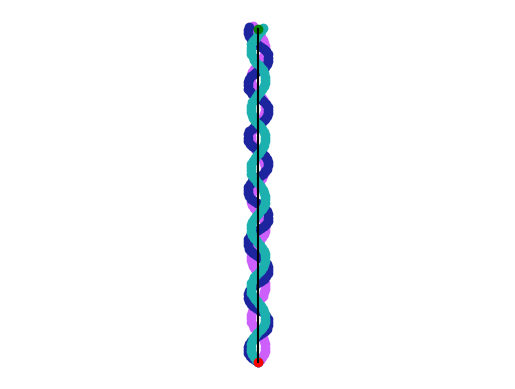

In [26]:

def naive_control(agent):
    agent.x += math.sin(agent.heading)
    agent.y += math.cos(agent.heading)
    reference = 0
    error = reference - agent.x
    K_ = 0.1
    control_signal = K_ * error
    agent.heading += control_signal

    #print(agent.x, agent.y)
    agent.positions_x.append(agent.x)
    agent.positions_y.append(agent.y)
    return agent

naive_agent1 = Agent()
naive_agent2 = Agent()
naive_agent3 = Agent()
fig, ax = plt.subplots()
plt.plot(naive_agent1.x, naive_agent1.y, 'ro') # plot a red dot to show where agents start
while naive_agent1.y < 100 or naive_agent2.y < 100 or naive_agent3.y < 100:
    # the following section differes greatly from the .py file since interactive plotting is not supported in notebooks
    # corresponding parts are commented out

    # ax.clear()
    # ax.plot(x_point, y_point, 'go')
    # ax.plot(x_line, y_line, color='black')
    if naive_agent1.y < 100:
        naive_agent1 = naive_control(naive_agent1)
    if naive_agent2.y < 100:
        naive_agent2 = naive_control(naive_agent2)
    if naive_agent3.y < 100:
        naive_agent3 = naive_control(naive_agent3)
    # ax.scatter(naive_agent.positions_x, naive_agent.positions_y, color=naive_agent.color)
    # ax.set_aspect('equal', adjustable='datalim')
    # ax.axis('off')
    # plt.draw()
    # plt.pause(0.01)
# notebook exclusive code, plotting only the final trajectory
# Plot the agent's path after the loop


# target position
x_point, y_point = 0, 100
x_line, y_line = [0, x_point], [0, y_point]
ax.plot(x_point, y_point, 'go')

# Plot the ideal path
ax.set_aspect('equal', adjustable='datalim')
ax.scatter(naive_agent1.positions_x, naive_agent1.positions_y, color=naive_agent1.color)
ax.scatter(naive_agent2.positions_x, naive_agent2.positions_y, color=naive_agent2.color)
ax.scatter(naive_agent3.positions_x, naive_agent3.positions_y, color=naive_agent3.color)
ax.plot(x_line, y_line, color='black')
ax.axis('off')
plt.show()

The naive.py file only runs one agent since it is easy to just run the file multiple times to produce multiple agents and I think it is too busy with three agents (even this static model is slightly busy). Here is the output from one of the runs from the naive.py file:

![naive plot](./plots/naive_control.png)

What we observe is that the controller overshoots. This is a common phenomena of all control schemes which will have an intial tendency to overshoot but ideally the error decreases over time. We can understand why over shooting example using the following thought experiment. Suppose for error $e$ it takes a control signal $u$ to correct it and for $\frac{e}{2}$ it takes a control signal of $\frac{u}{2}$. Starting at $e$ the controller applied a control signal of $u$ which if given sufficient time, would correct the error. However, by the time the plant is at $\frac{e}{2}$ the next control loop has started which added an additional $\frac{u}{2}$ control signal. This means a $u + \frac{u}{2}$ control is added to an error of only $e$ resulting in overshooting. 

The naive control is extra terrible in this case as the error over time never decreases but instead it oscillates. This is because the plant does not have direct control over the error. The error is positional error but the plant (representing a car) only has control over its heading. If this is confusing, realize that parallel parking is difficult becasue you can only control the heading of the car and your car does not move laterally. 